## **Load in data**

In [ ]:
# link & mount to google drive to import data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

In [ ]:
# import pre-processed data from google drive and store in dataframe using pandas function
# split the dataset into 6 different datasets, one for each class
# GAN model will generate samples for one class at a time, therefore dataframe needs to be split by class. Will be joined again after all samples have been generated.

df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/Single_attack/d_Botnet35.csv')
#df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/Single_attack/d_BruteForce35.csv')
#df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/Single_attack/d_DDoS35.csv')
#df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/Single_attack/d_DoS35.csv')
#df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/Single_attack/d_Portscan35.csv')
#df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/Single_attack/d_Benign35.csv')

In [ ]:
#ho salvato il file con 36 feature... la tolgo qui...
df = df.iloc[:, :-1]

In [ ]:
data_columns = df.columns

In [ ]:
pd.options.display.float_format = '{:,.20f}'.format

```
BENIGN                   1594422
Infiltration_Portscan     230853
DoS                       171620
DDoS                       95133
BruteForce                  7005
Botnet                       736
```


## **Define model architecture**

## Import

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
# Allow matplotlib images to render immediately.
%matplotlib inline

import seaborn as sns

from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential

In [ ]:
!pip install sdv
%pip install sdmetrics
from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import evaluate_quality
from sdv.evaluation.single_table import run_diagnostic



1.   Alpha (for LeakyReLU):
> * alpha is the slope of the negative part of the LeakyReLU activation function. It helps introduce a small, non-zero slope to the activation function for negative input values, preventing the neuron from being completely inactive.
> * A common value for alpha is in the range of 0.01 to 0.3. You can experiment with different values to see what works best for your specific dataset and model.

2.   Momentum (for Batch Normalization):
> * momentum is a parameter used in the update of the moving averages in batch normalization. It controls the contribution of the previous running mean and variance to the new estimates.
> * Common values for momentum are between 0.9 and 0.999. Higher values give more weight to the new batch, and lower values give more weight to the history.

3.   Dropout Rate (for Discriminator):
> * rate is the dropout rate, which represents the fraction of input units to drop during training.
> * A common value for rate is between 0.3 and 0.5. This means dropping 30% to 50% of the input units during training.





## Parametri

In [ ]:
alpha_leakyRelu = 0.15 #@param
momentumBN = 0.8 #@param
dropoutRate = 0.1 #@param

neuroni = 256 #@param

In [ ]:
#generator & discriminator parameters

batch_size = 2048 #@param
lr_d=0.0001 #@param
lr_g=0.0003 #@param

beta=0.5  #@param
noise_dim = 16  #@param

data_dim=35 #numeroFeatures


#training parameters
epochs = 6000 #@param
n_eval = 50 #@param

In [ ]:
#FONTE: https://machinelearningmastery.com/practical-guide-to-gan-failure-modes/

def plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist):
    # plot loss
    plt.subplot(2, 1, 1)
    plt.plot(d1_hist, label='d-loss-real')
    plt.plot(d2_hist, label='d-loss-fake')
    plt.plot(g_hist, label='g-loss')
    plt.legend()

    # plot discriminator accuracy
    plt.subplot(2, 1, 2)
    plt.plot(a1_hist, label='acc-real')
    plt.plot(a2_hist, label='acc-fake')
    plt.legend()

    plt.show()

## **Architettura Modello**

Nuovo Codice con più layer
* Fonte codice base: https://github.com/CameronSwart/GAN-IDS

#### Vecchio



```
#INIZIALE SU VANILLAGAN_2

def build_generator(data_dim, noise_dim):
        model = Sequential(name="Generatore")
        model.add(Dense(128, activation=LeakyReLU(alpha_leakyRelu), kernel_initializer="he_uniform", input_dim=noise_dim))
        model.add(BatchNormalization(momentum=momentumBN))
        model.add(Dense(256, activation=LeakyReLU(alpha_leakyRelu), kernel_initializer="he_uniform"))
        model.add(BatchNormalization(momentum=momentumBN))
        model.add(Dense(512, activation=LeakyReLU(alpha_leakyRelu), kernel_initializer="he_uniform"))
        model.add(BatchNormalization(momentum=momentumBN))
        model.add(Dense(data_dim, activation="sigmoid")) # Use sigmoid activation in the output layer to constrain values to [0, 1]
        return model


    def build_discriminator(data_dim):
        model = Sequential(name="Discriminatore")
        model.add(Dense(512, activation=LeakyReLU(alpha_leakyRelu), kernel_initializer="he_uniform"))
        model.add(Dropout(dropoutRate))
        model.add(Dense(256, activation=LeakyReLU(alpha_leakyRelu), kernel_initializer="he_uniform"))
        model.add(Dropout(dropoutRate))
        model.add(Dense(128, activation=LeakyReLU(alpha_leakyRelu), kernel_initializer="he_uniform"))
        model.add(Dense(1, activation="sigmoid"))
        model.compile(loss="binary_crossentropy", optimizer=optimizerD, metrics=["accuracy"])
        return model
```



#### Modello

In [ ]:
def gan_system():

    def build_generator(data_dim, noise_dim):
        model = Sequential(name="Generatore")
        model.add(Dense(neuroni, activation=LeakyReLU(alpha_leakyRelu), kernel_initializer="he_uniform", input_dim=noise_dim))
        model.add(BatchNormalization(momentum=momentumBN))
        model.add(Dense(neuroni*2, activation=LeakyReLU(alpha_leakyRelu), kernel_initializer="he_uniform"))
        model.add(BatchNormalization(momentum=momentumBN))
        model.add(Dense(neuroni*4, activation=LeakyReLU(alpha_leakyRelu), kernel_initializer="he_uniform"))
        model.add(BatchNormalization(momentum=momentumBN))
        model.add(Dense(data_dim, activation="sigmoid")) # Use sigmoid activation in the output layer to constrain values to [0, 1]
        return model

    generator = build_generator(data_dim, noise_dim)

    optimizerD = tf.keras.optimizers.Adam(learning_rate=lr_d)

    def build_discriminator(data_dim):
        model = Sequential(name="Discriminatore")
        model.add(Dense(neuroni*4, activation=LeakyReLU(alpha_leakyRelu), kernel_initializer="he_uniform", input_dim=data_dim))
        model.add(Dropout(dropoutRate))
        model.add(Dense(neuroni*2, activation=LeakyReLU(alpha_leakyRelu), kernel_initializer="he_uniform"))
        model.add(Dropout(dropoutRate))
        model.add(Dense(neuroni, activation=LeakyReLU(alpha_leakyRelu), kernel_initializer="he_uniform"))
        model.add(Dropout(dropoutRate)) #prima non c'era!!!
        model.add(Dense(1, activation="sigmoid"))
        model.compile(loss="binary_crossentropy", optimizer=optimizerD, metrics=["accuracy"])
        return model

    discriminator = build_discriminator(data_dim)

    optimizerGAN = tf.keras.optimizers.Adam(learning_rate=lr_g)

    def build_gan(generator, discriminator):
        # make weights in the discriminator not trainable
        discriminator.trainable = False
        # connect generator and dicriminator
        model = Sequential(name="GAN")
        model.add(generator)
        model.add(discriminator)
        model.compile(loss = "binary_crossentropy", optimizer = optimizerGAN)
        return model


    gan = build_gan(generator, discriminator)

    return gan, generator, discriminator



def train(gan, generator, discriminator, data, noise_dim, n_epochs, n_batch, n_eval):
    #Half batch size for updateting discriminator
    half_batch = int(n_batch / 2)

    d1_hist, d2_hist, g_hist, a1_hist, a2_hist = list(), list(), list(), list(), list()

    #generate class labels for fake = 0 and real = 1
    valid = np.ones((half_batch, 1))
    fake = np.zeros((half_batch, 1))
    y_gan = np.ones((n_batch, 1))

    np.random.seed(3) # used for retestability

    #training loop
    for j in range(n_epochs):
        #select random batch from the real numerical data
        idx = np.random.randint(0, data.shape[0], half_batch)
        real_data = data[idx]

        #generate fake samples from the noise
        noise = np.random.normal(0, 1, (half_batch, noise_dim))
        fake_data = generator.predict(noise)

        #train the discriminator and return losses
        d_loss_real, d_acc1 = discriminator.train_on_batch(real_data, valid)
        d_loss_fake, d_acc2 = discriminator.train_on_batch(fake_data, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        #generate noise for generator input and  train the generator (to have the discriminator label samples as valid)
        noise = np.random.normal(0, 1, (n_batch, noise_dim))
        g_loss = gan.train_on_batch(noise, y_gan)

        d1_hist.append(d_loss_real)
        d2_hist.append(d_loss_fake)
        g_hist.append(g_loss)
        a1_hist.append(d_acc1)
        a2_hist.append(d_acc2)

        #evaluate progress
        if (j+1) % n_eval == 0:
            print('==>> Epoch %d ==> dRealLoss=%.3f, dFakeLoss=%.3f, dTOTLoss=%.3f, gLoss=%.3f, accR=%d, accF=%d' % (j, d_loss_real, d_loss_fake,d_loss, g_loss, int(100*d_acc1), int(100*d_acc2)))

    #plot losses after training
    plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist)


In [ ]:
gan, generator, discriminator = gan_system()

#### Summary Architettura

In [ ]:
gan.summary()

Model: "GAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generatore (Sequential)     (None, 35)                704291    
                                                                 
 Discriminatore (Sequential  (None, 1)                 693249    
 )                                                               
                                                                 
Total params: 1397540 (5.33 MB)
Trainable params: 700707 (2.67 MB)
Non-trainable params: 696833 (2.66 MB)
_________________________________________________________________


In [ ]:
generator.summary()

Model: "Generatore"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               4352      
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 batch_normalization_2 (Bat  (None, 1024)              4

In [ ]:
discriminator.summary()

Model: "Discriminatore"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              36864     
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 1)              

## **Training & Generazione**

In [ ]:
#preparo il dataframe in np array
real_data = df.to_numpy()

Output streaming troncato alle ultime 5000 righe.
32/32 [==============================] - 0s 3ms/step
==>> Epoch 1099 ==> dRealLoss=0.661, dFakeLoss=0.652, dTOTLoss=0.657, gLoss=0.830, accR=69, accF=56
32/32 [==============================] - 0s 3ms/step
==>> Epoch 1149 ==> dRealLoss=0.665, dFakeLoss=0.632, dTOTLoss=0.648, gLoss=0.841, accR=70, accF=63
32/32 [==============================] - 0s 3ms/step
==>> Epoch 1199 ==> dRealLoss=0.651, dFakeLoss=0.649, dTOTLoss=0.650, gLoss=0.825, accR=70, accF=59
32/32 [==============================] - 0s 3ms/step
==>> Epoch 1249 ==> dRealLoss=0.631, dFakeLoss=0.671, dTOTLoss=0.651, gLoss=0.805, accR=72, accF=54
32/32 [==============================] - 0s 3ms/step
==>> Epoch 1299 ==> dRealLoss=0.641, dFakeLoss=0.671, dTOTLoss=0.656, gLoss=0.799, accR=71, accF=54
32/32 [==============================] - 0s 4ms/step
==>> Epoch 1349 ==> dRealLoss=0.668, dFakeLoss=0.660, dTOTLoss=0.664, gLoss=0.857, accR=64, accF=58
32/32 [=========================

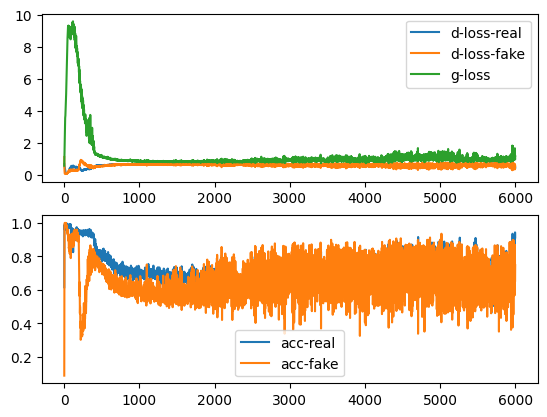

In [ ]:
train(gan, generator, discriminator, real_data, noise_dim,
      epochs, batch_size, n_eval)

In [ ]:
np.random.seed(3) # used for retestability

num_rows_gen = df.shape[0] #quante righe verranno generate
#num_rows_gen = 1000 #quante righe verranno generate

noise = np.random.normal(0, 1, (num_rows_gen, noise_dim))
X = generator.predict(noise)

17/17 [==============================] - 0s 3ms/step


In [ ]:
gen_samples = pd.DataFrame(X, columns=data_columns)

#### Salvo csv

In [ ]:
#SALVO CSV data gen
#gen_samples.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/GANgen/Valutazione/tentativo2/genBotnet.csv', index = False)
#gen_samples.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/GANgen/Valutazione/tentativo2/genBruteforce.csv', index = False)
#gen_samples.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/GANgen/Valutazione/tentativo2/genDDoS.csv', index = False)
#gen_samples.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/GANgen/Valutazione/tentativo2/genDoS.csv', index = False)
#gen_samples.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/GANgen/Valutazione/tentativo2/genPortscan.csv', index = False)
#gen_samples.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/GANgen/Valutazione/tentativo2/genBenign.csv', index = False)

#### Preparo x valutazione Quant&Qualit

In [ ]:
print(df.shape)
print(gen_samples.shape)

(515, 35)
(515, 35)


In [ ]:
df.head()

,FlowDuration,BwdPacketLengthStd,DstPort,TotalLengthofFwdPacket,FlowIATMax,PacketLengthVariance,PacketLengthStd,BwdPacketLengthMax,FlowPackets/s,RSTFlagCount,...,FlowIATMean,BwdInitWinBytes,FwdIATMax,FwdIATStd,FwdHeaderLength,BwdBulkRateAvg,BwdHeaderLength,FwdIATTotal,FwdSegSizeMin,FWDInitWinBytes
0,0.00069653335074660000,0.00336931188828489990,0.12330418593294570351,0.00569833442266699970,0.00059465131814370005,0.35033164666025967682,0.59188820452874346678,0.00655401945724520037,0.00020736539969620001,0.00000000000000000000,...,0.00002374523031722300,0.01950102998397799936,0.00063916736442430004,0.00021039825299439999,0.50598875580542646002,0.00000000000000000000,0.51060448627834487123,0.00069654167827560003,0.45454545454545458583,0.12500190737773708705
1,0.00074287501857179996,0.00952985313655499953,0.12330418593294570351,0.00001515121848430008,0.00072005992946610000,0.00024299328552560001,0.01558824189976630060,0.00655401945724520037,0.00003364432659904602,0.00000000000000000000,...,0.00016148906373270001,0.00361638818951700008,0.00072999246357510002,0.00052317587655070004,0.50140552432168172814,0.00000000000000000000,0.50204755210561702317,0.00074288334571469999,0.45454545454545458583,0.12500190737773708705
2,0.00054386668026329995,0.00952985313655499953,0.12330418593294570351,0.00007948562312532809,0.00052283449228310004,0.00519682978477729960,0.07208904067039109687,0.00655401945724520037,0.00004595811151530935,0.00000000000000000000,...,0.00011822640044270000,0.00373846036469060007,0.00053301724854380001,0.00038166407615159998,0.50140552432168172814,0.00000000000000000000,0.50204755210561702317,0.00054387500906450000,0.45454545454545458583,0.12500190737773708705
3,0.00177155004428870009,0.00847602331560090051,0.12330418593294570351,0.00001507351992797033,0.00174721220632029998,0.00020170351850010000,0.01420223639080120046,0.00655401945724520037,0.00001723950727243966,0.00000000000000000000,...,0.00030808972781799998,0.00361638818951700008,0.00175175191232910003,0.00112635075745090010,0.50171107308726470286,0.00000000000000000000,0.50235315689750015267,0.00177153336285879991,0.45454545454545458583,0.12500190737773708705
4,0.00147343337016909992,0.00236406560893340006,0.12330418593294570351,0.01139853361068609953,0.00128319451108110005,0.54190677873835790823,0.73614317815106988796,0.00655401945724520037,0.00017908860481750000,0.00000000000000000000,...,0.00002725345775331279,0.01915007248035400025,0.00139866819354609998,0.00037377759101849998,0.50904424346125631828,0.00000000000000000000,0.52068944441048836680,0.00147344169122399994,0.45454545454545458583,0.12500190737773708705


In [ ]:
gen_samples.head()

,FlowDuration,BwdPacketLengthStd,DstPort,TotalLengthofFwdPacket,FlowIATMax,PacketLengthVariance,PacketLengthStd,BwdPacketLengthMax,FlowPackets/s,RSTFlagCount,...,FlowIATMean,BwdInitWinBytes,FwdIATMax,FwdIATStd,FwdHeaderLength,BwdBulkRateAvg,BwdHeaderLength,FwdIATTotal,FwdSegSizeMin,FWDInitWinBytes
0,0.00000000000000000000,0.00007764228939777240,0.13097029924392700195,0.00000000000000000000,0.00000000000000000000,0.64067441225051879883,0.99809956550598144531,0.00106295477598905563,0.00000000000000000000,0.00000092420231112555,...,0.00000000000000000000,0.06282956898212432861,0.00000000000000000000,0.00000000000000000000,0.54017096757888793945,0.00000070103675398059,0.80440789461135864258,0.00000000000000000000,0.55832374095916748047,0.07044158875942230225
1,0.00093509978614747524,0.00896840542554855347,0.12202861160039901733,0.00008679462916916236,0.00093771831598132849,0.00017748381651472300,0.01639692485332489014,0.00680382782593369484,0.00002777659210551064,0.00000008165173426278,...,0.00014125368034001440,0.00393084576353430748,0.00115523708518594503,0.00059189990861341357,0.49943134188652038574,0.00000008517541516539,0.49627611041069030762,0.00099908665288239717,0.45439779758453369141,0.12447488307952880859
2,0.00093415135052055120,0.00908259954303503036,0.12192022800445556641,0.00002695202419999987,0.00088779564248397946,0.00012237115879543126,0.01565710082650184631,0.00667157908901572227,0.00003064834163524210,0.00000006255788775889,...,0.00015790638281032443,0.00362500664778053761,0.00096644024597480893,0.00059274898376315832,0.49854853749275207520,0.00000006814441633196,0.49481144547462463379,0.00088468345347791910,0.45189321041107177734,0.12429527193307876587
3,0.00088118168059736490,0.00902601052075624466,0.12328552454710006714,0.00005362238152883947,0.00088456668891012669,0.00018640448979567736,0.01619129814207553864,0.00702031655237078667,0.00002338570084248204,0.00000006377469929930,...,0.00015906606859061867,0.00373930856585502625,0.00108514295425266027,0.00062964309472590685,0.50353783369064331055,0.00000005962942850601,0.50085252523422241211,0.00088268582476302981,0.45719659328460693359,0.12571975588798522949
4,0.00081592681817710400,0.00926669966429471970,0.12304511666297912598,0.00001440239338990068,0.00078326073708012700,0.00012528517981991172,0.01555677317082881927,0.00697327917441725731,0.00002467283229634631,0.00000005948572834313,...,0.00014955020742490888,0.00363882281817495823,0.00085472629871219397,0.00057046330766752362,0.50298905372619628906,0.00000005671298097809,0.49984318017959594727,0.00083720003021880984,0.45578384399414062500,0.12547247111797332764


#Valutazione

Text(0.5, 1.0, 'Dati generati')

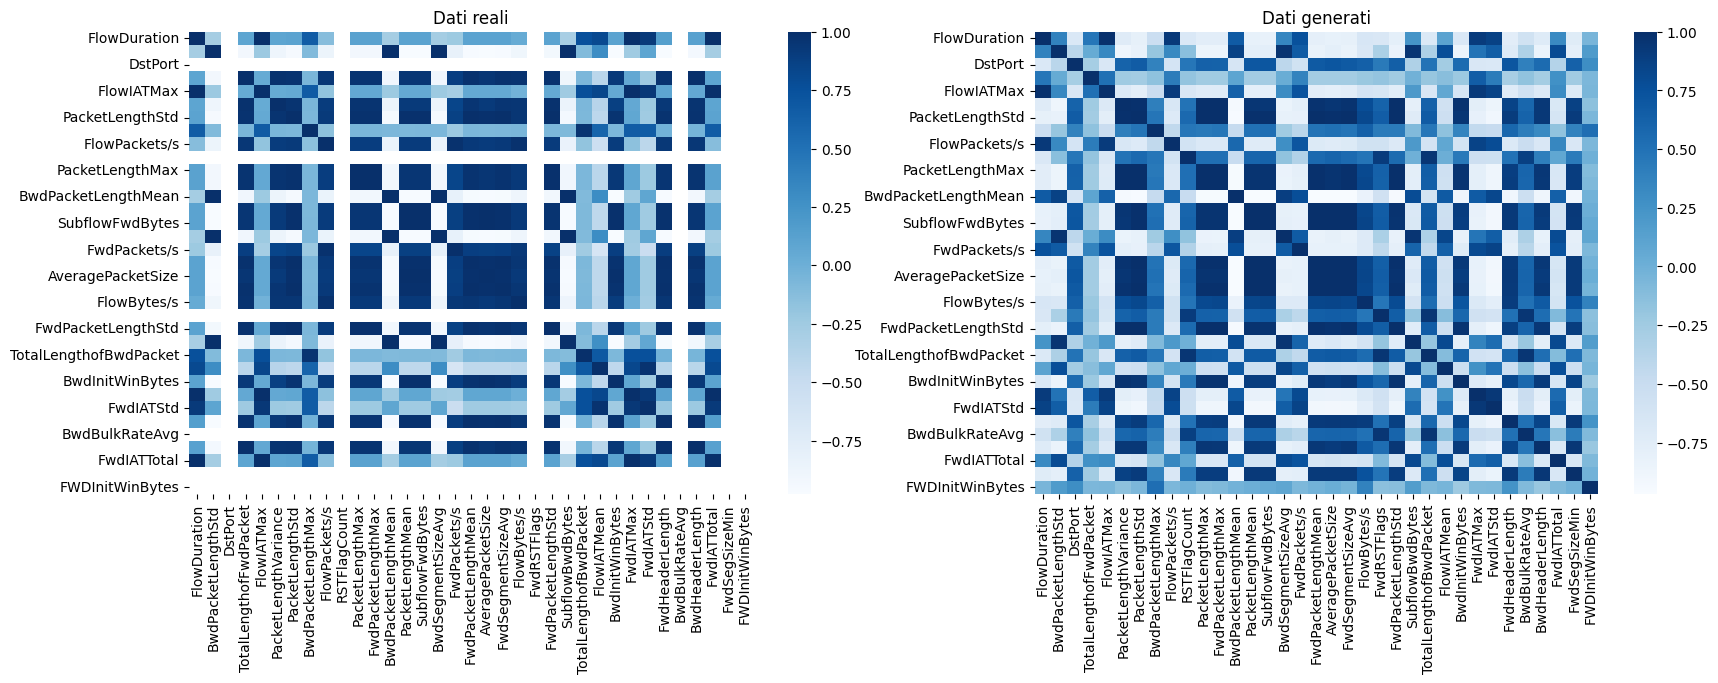

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.heatmap(df.corr(), annot=False, ax=ax[0], cmap="Blues")
sns.heatmap(gen_samples.corr(), annot=False, ax=ax[1], cmap="Blues")
ax[0].set_title("Dati reali")
ax[1].set_title("Dati generati")

In [ ]:
real_data = df.to_numpy()
generated_data = gen_samples.to_numpy()

In [ ]:
from scipy.stats import wasserstein_distance

# Flatten the arrays for 1D distribution
real_flat = real_data.flatten()
generated_flat = generated_data.flatten()

# Compute Wasserstein distance
w_distance = wasserstein_distance(real_flat, generated_flat)

print('Wasserstein Distance delle distribuzioni:', w_distance)

Wasserstein Distance delle distribuzioni: 0.004435433831807171


In [ ]:
real_col = df['FlowDuration'].to_numpy()
gen_col = gen_samples['FlowDuration'].to_numpy()

* ***KLDivergence*** ==> you can use it to measure the difference between the distribution of your real data and the distribution of the generated data.

```
KLDivergence = 0 !!!! (mi indica quante info perdo)
```



In [ ]:
kl = tf.keras.losses.KLDivergence()
print("KLDivergence FlowDuration:", kl(real_col, gen_col).numpy())

KLDivergence FlowDuration: 0.26307628


In [ ]:
w_dist_feature = wasserstein_distance(real_col, gen_col)
print("Wasserstein Distance per la feature FlowDuration:", w_dist_feature)

Wasserstein Distance per la feature FlowDuration: 0.000311781448169549


In [ ]:
# Choose the column you want to check
# 0 = FlowDuration
# 1 = BwdPacketLengthStd
# 2 = DstPort
# 3 = TotalLenghtofFwdPacket
# 4 = FlowIATMax
# 5 = PacketLengthVariance

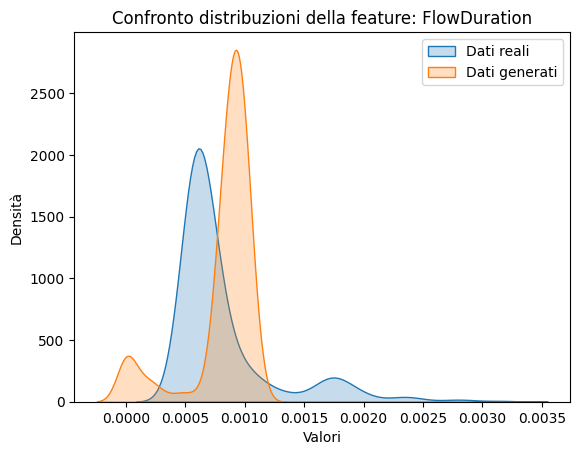

In [ ]:
column_to_compare = 0
# Extract the selected column for each array
real_column = real_data[:, column_to_compare]
generated_column = generated_data[:, column_to_compare]

# Plot the KDE for both distributions
sns.kdeplot(real_column, label='Dati reali', fill=True)
sns.kdeplot(generated_column, label='Dati generati', fill=True)

# Add labels and legend
plt.title(f'Confronto distribuzioni della feature: {df.columns[column_to_compare]}')
plt.xlabel('Valori')
plt.ylabel('Densità')
plt.legend()
#salva in Drive
#images_dir = '/content/drive/MyDrive/Colab Notebooks/progettoTesi/grafici_pdf'
#plt.savefig(f"{images_dir}/distributionFeatureFlowDuration_genGAN_t2.pdf", dpi=200, format='pdf') ###!!!!!!!!!!!!!! CAMBIARE TENTATIVI CON N°
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

real_data_first_column = real_data[:, 0]
gen_data_first_column = generated_data[:, 0]

np.random.seed(3)
# Downsample gen_data_first_column to match the size of real_data_first_column
downsampled_gen_data_first_column = np.random.choice(gen_data_first_column, size=(len(real_data_first_column),), replace=True) #False

# Calculate the Mean Squared Error
mse = mean_squared_error(real_data_first_column, downsampled_gen_data_first_column)

print(f"Mean Squared Error: {mse}")

Mean Squared Error: 2.4275488140130896e-07




```
Interpretation:

*   A smaller MSE indicates that the generated data is closer to the real data in terms of the selected feature.
*  Closer to 0 suggests better performance for that specific feature.


```



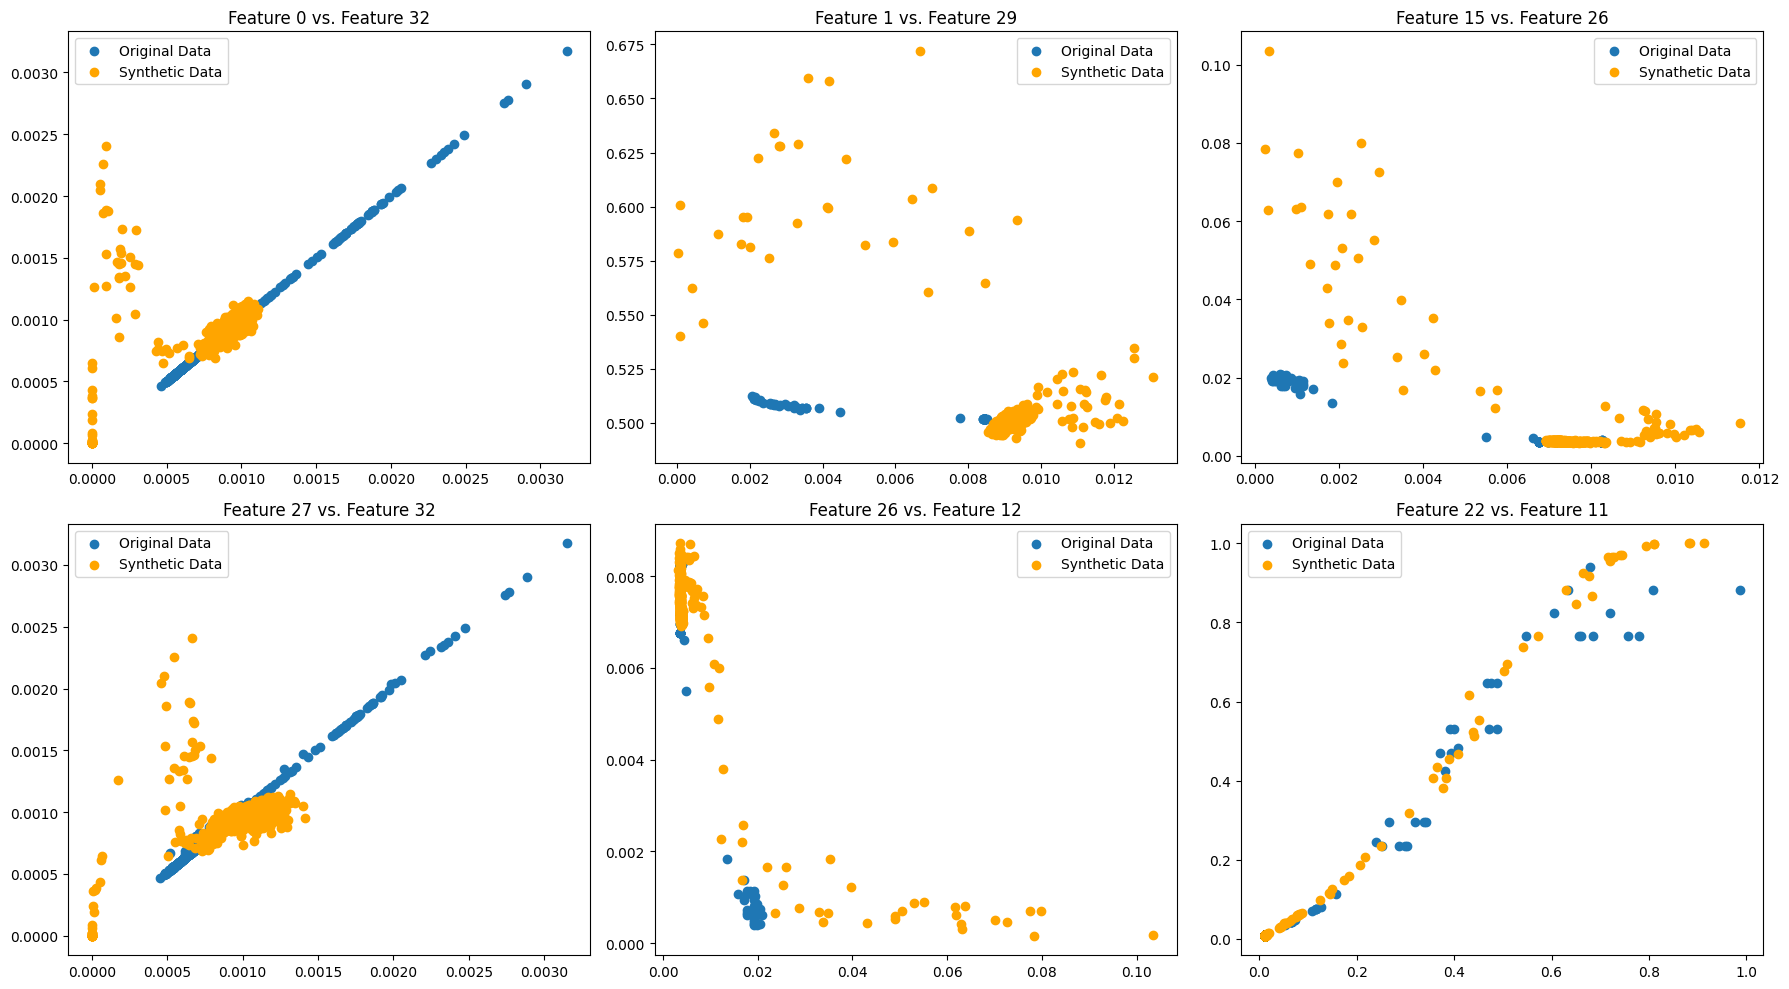

In [ ]:

# Create subplots with a 2x3 grid (2 rows, 3 columns)
fig, axs = plt.subplots(2, 3, figsize=(18, 10))


axs[0, 0].scatter(df.iloc[:, 0], df.iloc[:, 32], label='Original Data')
axs[0, 0].scatter(gen_samples.iloc[:, 0], gen_samples.iloc[:, 32], label='Synthetic Data', c='orange')
axs[0, 0].set_title("Feature 0 vs. Feature 32")
axs[0, 0].legend()


axs[0, 1].scatter(df.iloc[:, 1], df.iloc[:, 29], label='Original Data')
axs[0, 1].scatter(gen_samples.iloc[:, 1], gen_samples.iloc[:, 29], label='Synthetic Data', c='orange')
axs[0, 1].set_title("Feature 1 vs. Feature 29")
axs[0, 1].legend()

axs[0, 2].scatter(df.iloc[:, 15], df.iloc[:, 26], label='Original Data')
axs[0, 2].scatter(gen_samples.iloc[:, 15], gen_samples.iloc[:, 26], label='Synathetic Data', c='orange')
axs[0, 2].set_title("Feature 15 vs. Feature 26")
axs[0, 2].legend()

axs[1, 0].scatter(df.iloc[:, 27], df.iloc[:, 32], label='Original Data')
axs[1, 0].scatter(gen_samples.iloc[:, 27], gen_samples.iloc[:, 32], label='Synthetic Data', c='orange')
axs[1, 0].set_title("Feature 27 vs. Feature 32")
axs[1, 0].legend()

axs[1, 1].scatter(df.iloc[:, 26], df.iloc[:, 12], label='Original Data')
axs[1, 1].scatter(gen_samples.iloc[:, 26], gen_samples.iloc[:, 12], label='Synthetic Data', c='orange')
axs[1, 1].set_title("Feature 26 vs. Feature 12")
axs[1, 1].legend()

axs[1, 2].scatter(df.iloc[:, 22], df.iloc[:, 11], label='Original Data')
axs[1, 2].scatter(gen_samples.iloc[:, 22], gen_samples.iloc[:, 11], label='Synthetic Data', c='orange')
axs[1, 2].set_title("Feature 22 vs. Feature 11")
axs[1, 2].legend()

plt.tight_layout()
plt.show()

* The Pearson coefficient measures whether two columns are linearly correlated
* the Spearman measures whether they are monotonically related.

#Valutazione SDV
*   https://github.com/sdv-dev/SDV
*   https://docs.sdv.dev/sdv



In [ ]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df)

In [ ]:
quality_report = evaluate_quality(
    real_data=df,
    synthetic_data=gen_samples,
    metadata=metadata)

Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|██████████| 595/595 [00:35<00:00, 16.61it/s]

Overall Score: 45.05%

Properties:
- Column Shapes: 31.22%
- Column Pair Trends: 58.88%


In [ ]:
diagnostic_report = run_diagnostic(
    real_data=df,
    synthetic_data=gen_samples,
    metadata=metadata)

Generating report ...
(2/2) Evaluating Data Structure: : 100%|██████████| 1/1 [00:00<00:00, 297.93it/s]

Overall Score: 82.27%

Properties:
- Data Validity: 64.55%
- Data Structure: 100.0%
